In [1]:
import h5py
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, optimizers, activations, initializers,regularizers, constraints
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D,Convolution2D, MaxPooling1D, AlphaDropout, Layer, LSTM, Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
#from tensorflow_addons.layers import MultiHeadAttention
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn, json
import scipy.io as io
from typing import Any, Dict
import logging, sys
from attention import Attention
logging.disable(sys.maxsize)
path = '/home/maria/'
sys.path.insert(0, path + "AMC/includes")
from clr_callback import *
import matplotlib.pyplot as plt

2022-10-18 10:15:15.405553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
classes = ['LFM', 'BFSK', 'BPSK', 'CW', 'SFW', 'SIN','EXP', 'BASK']
dt = np.dtype(float)
dataset_path = path + 'Dataset_trials/'




In [ ]:
with h5py.File(dataset_path +'X_train.mat', 'r') as f:
    X_train = np.array(f['X_train']).T
with h5py.File(dataset_path +'X_val.mat', 'r') as f:
    X_val = np.array(f['X_val']).T
lbl_train = io.loadmat(dataset_path + 'lbl_train.mat')['lbl_train']
lbl_val = io.loadmat(dataset_path + 'lbl_val.mat')['lbl_val']

Y_val = io.loadmat(dataset_path + 'Y_val.mat')
Y_val = Y_val['Y_val']
Y_train = io.loadmat(dataset_path + 'Y_train.mat')
Y_train = Y_train['Y_train']
print("X val shape: ", X_val.shape)
print("Y train shape: ", Y_train.shape)
print("Y val shape: ", Y_val.shape)
print("Label train shape: ", lbl_train.shape)
print("Label val shape: ", lbl_val.shape)

In [3]:
with h5py.File(dataset_path +'X_test.mat', 'r') as f:
    X_test = np.array(f['X_test']).T
lbl_test = io.loadmat(dataset_path + 'lbl_test.mat')['lbl_test']
Y_test = io.loadmat(dataset_path + 'Y_test.mat')
Y_test = Y_test['Y_test']
print("X test shape: ", X_test.shape)
print("Y test shape: ", Y_test.shape)
print("Label test shape: ", lbl_test.shape)

X test shape:  (40800, 1024, 2)
Y test shape:  (40800, 8)
Label test shape:  (40800, 6)


In [4]:
np.random.seed(2022)

In [4]:

X_train, Y_train, lbl_train = sklearn.utils.shuffle(X_train[:], Y_train[:], lbl_train[:], random_state=2022)
X_val, Y_val, lbl_val = sklearn.utils.shuffle(X_val[:], Y_val[:], lbl_val[:], random_state=2022)


In [4]:
X_test, Y_test, lbl_test = sklearn.utils.shuffle(X_test[:], Y_test[:], lbl_test[:], random_state=2022)

In [8]:
print(Y_test[1, :])
print(Y_test[3, :])
print(Y_test[6, :])
print(Y_test[9, :])
print(Y_test[17, :])
print(Y_test[365, :])

[0 0 0 0 0 1 0 0]
[0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0]
[0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 0 0]


In [ ]:
print(Y_test[3, :])

In [5]:
model = keras.models.load_model("/home/maria/8_signals/Results_attention/best_model.h5")

2022-10-18 10:15:40.435485: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-18 10:15:40.436378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-18 10:15:40.493616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 10:15:40.493756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-10-18 10:15:40.493778: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-18 10:15:40.495197: I tensorflow/stream_executor/platform/default/ds

In [6]:
def getConfusionMatrixPlot(true_labels, predicted_labels,title):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)

    # create figure
    width = 18
    height = width / 1.618
    fig = plt.figure(figsize=(width, height))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = classes
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    plt.title(title)
    return plt


def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

In [8]:
output_path = path +"8_signals/Results_attention"

2022-10-18 10:15:56.014437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-18 10:15:56.030994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3602170000 Hz
2022-10-18 10:15:56.802855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-18 10:15:57.029959: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Overall Accuracy:  0.7495833333333334
Overall Accuracy:  0.92125
Overall Accuracy:  0.9845833333333334
Overall Accuracy:  0.9970833333333333
Overall Accuracy:  0.9991666666666666


/tmp/ipykernel_2953183/1412440523.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(width, height))


Overall Accuracy:  0.9995833333333334
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0
Overall Accuracy:  1.0


<Figure size 1800x1112.48 with 0 Axes>

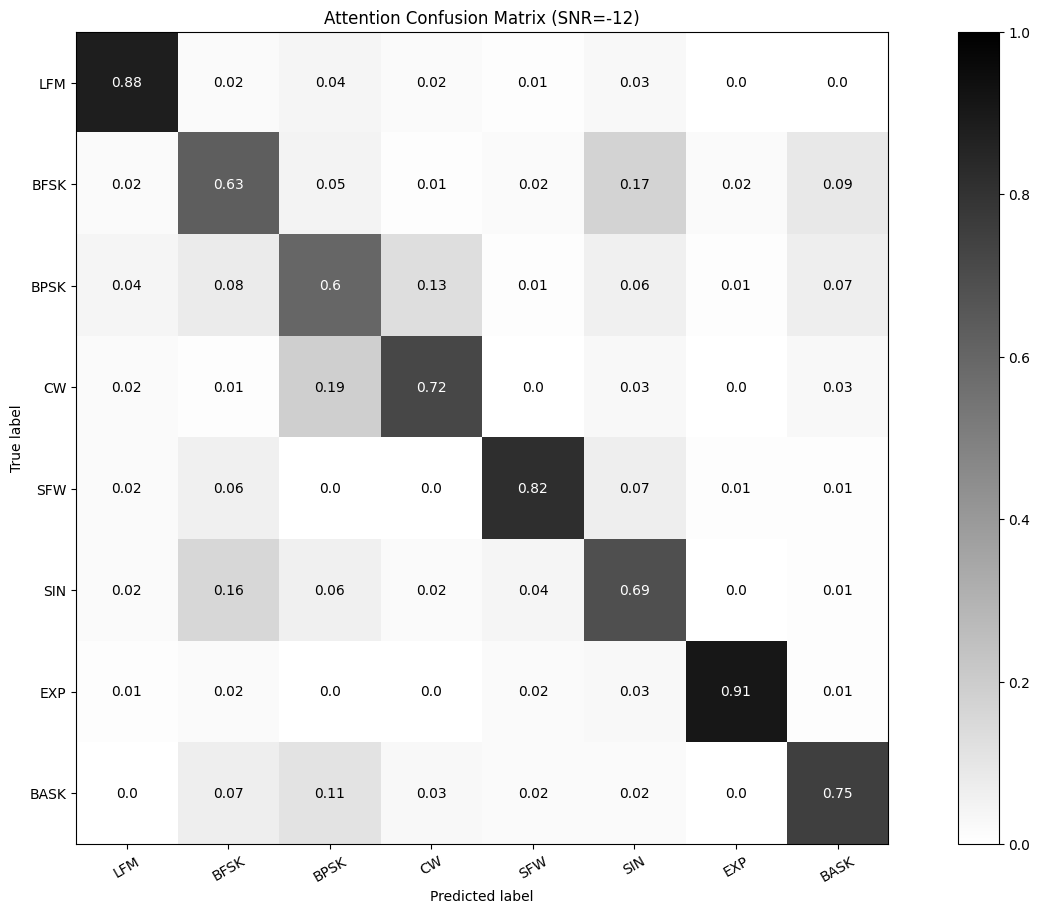

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

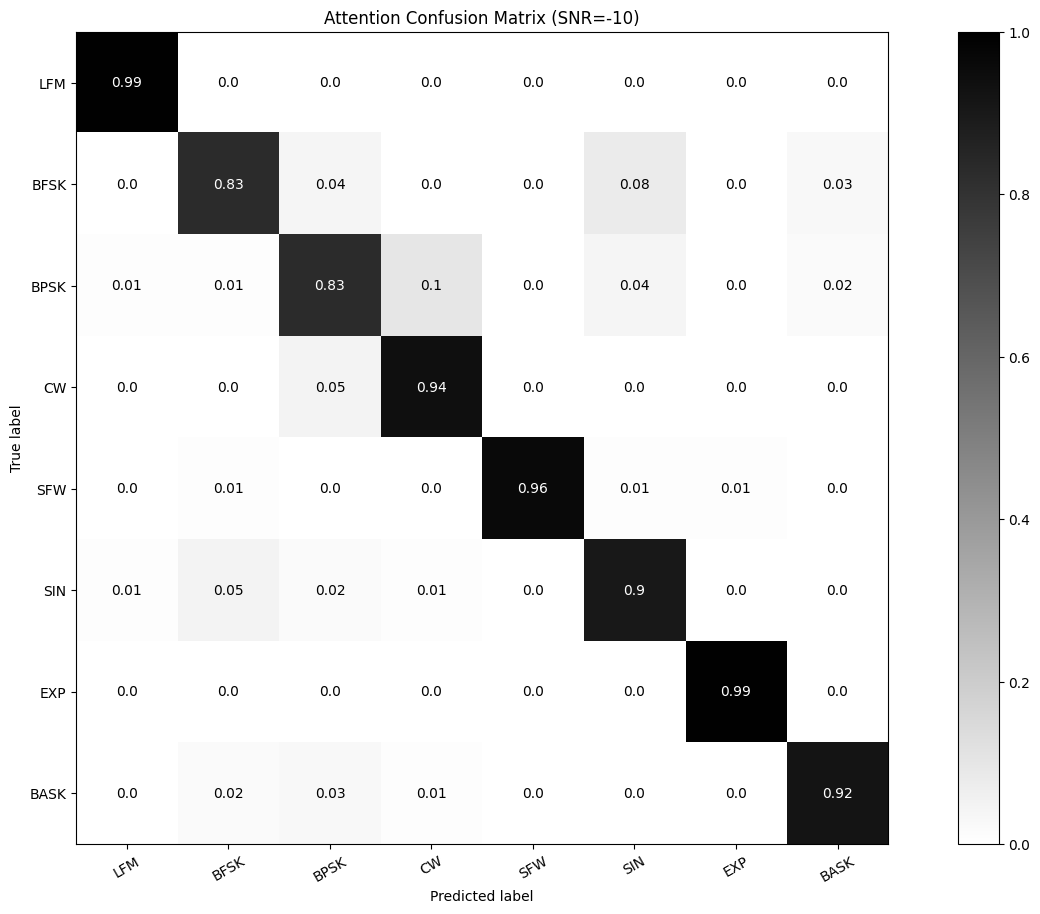

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

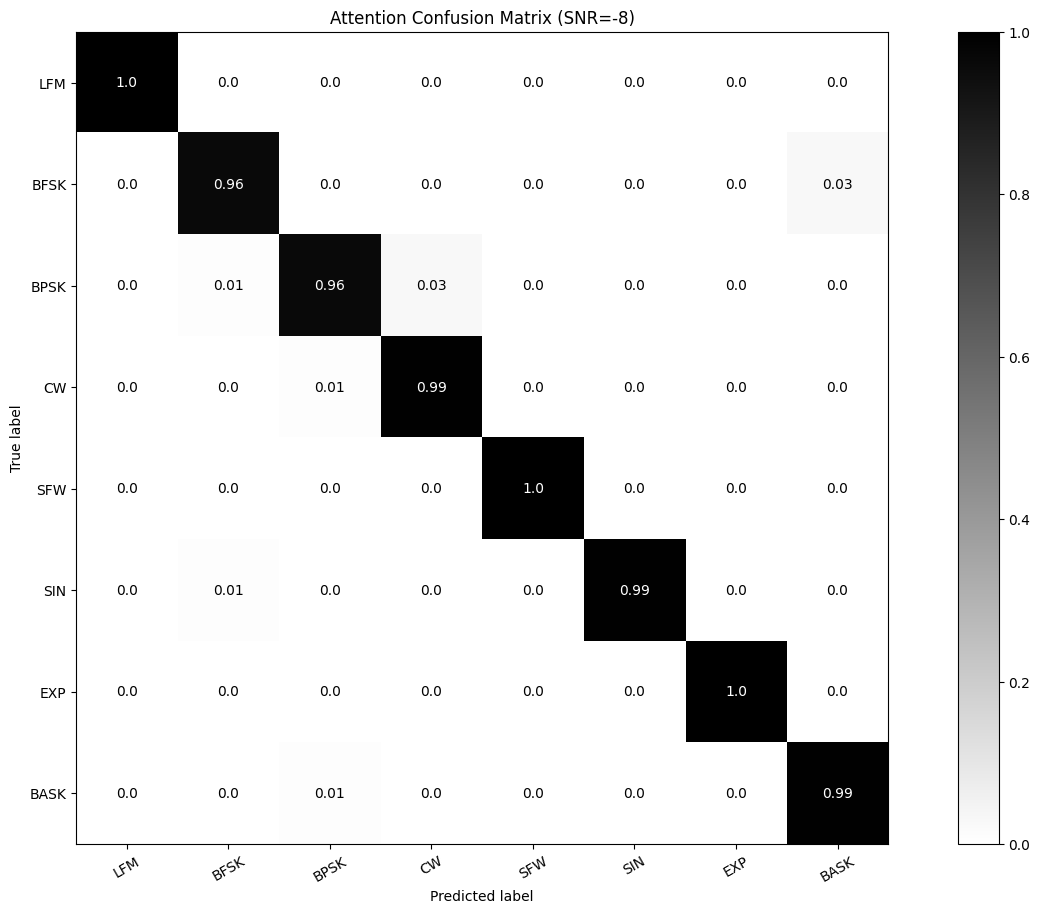

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

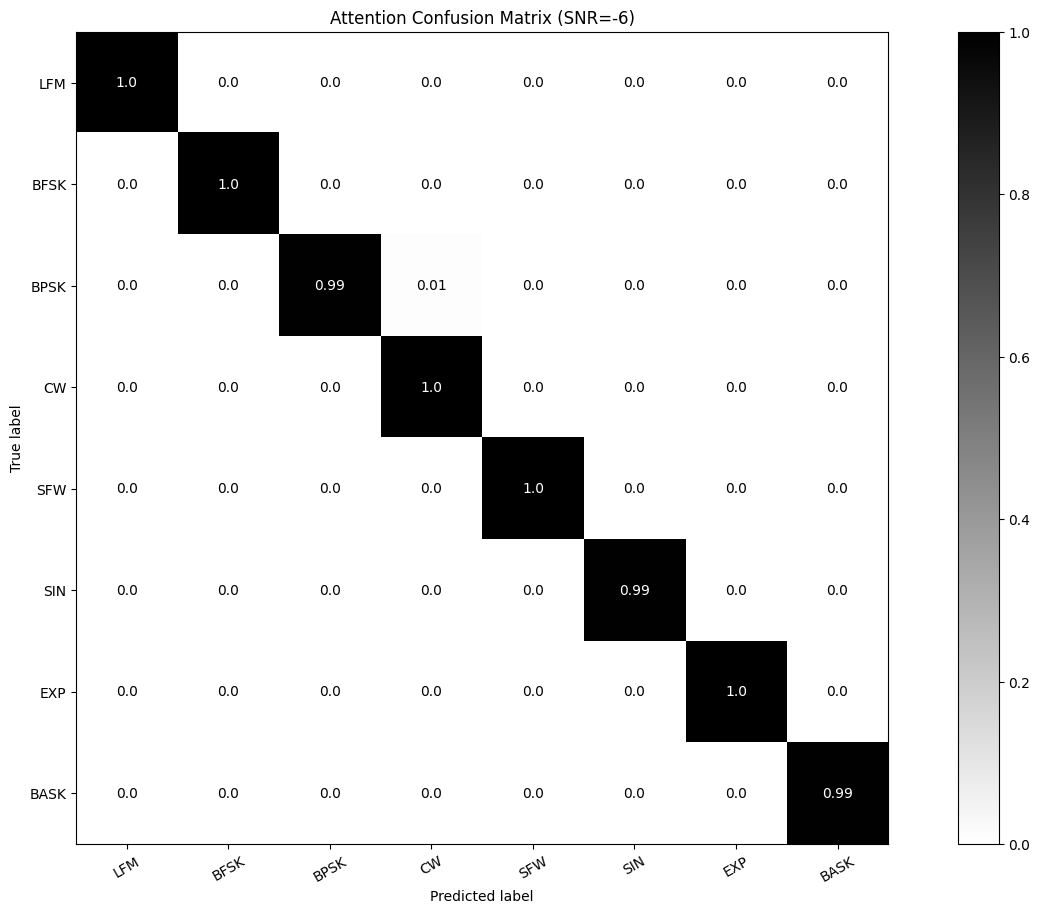

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

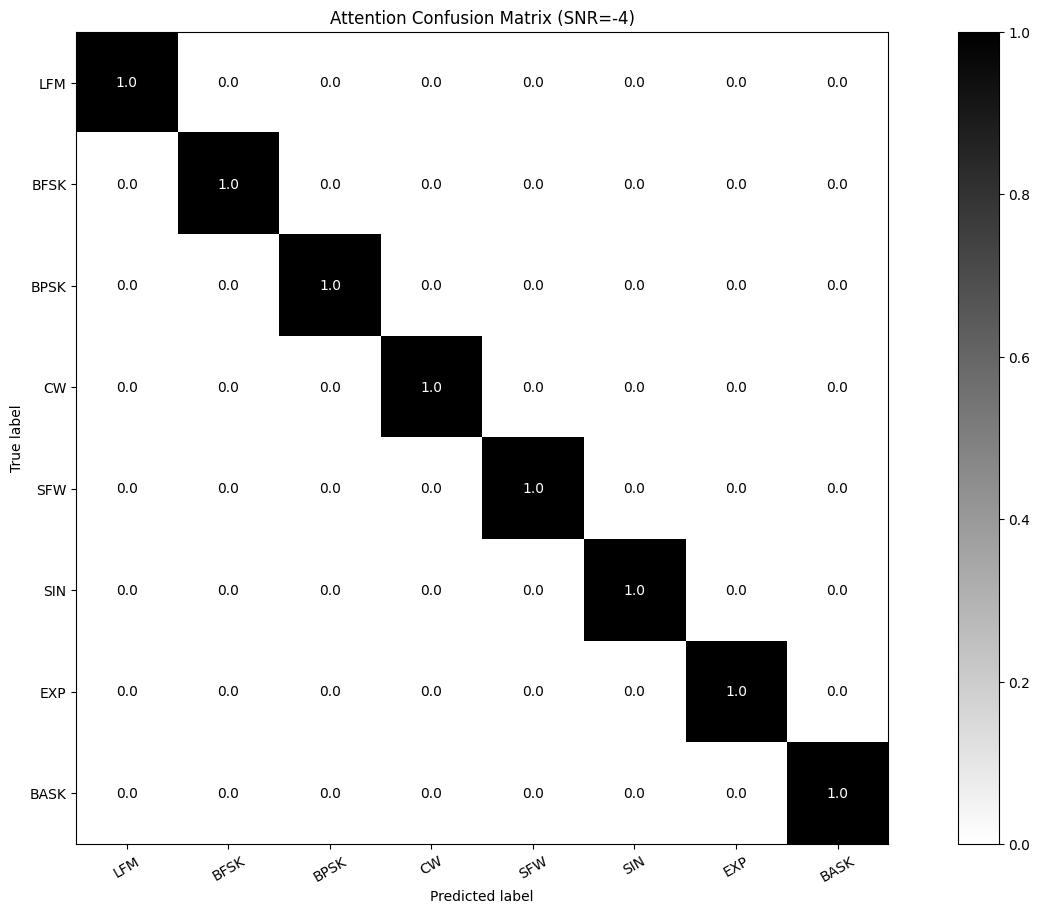

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

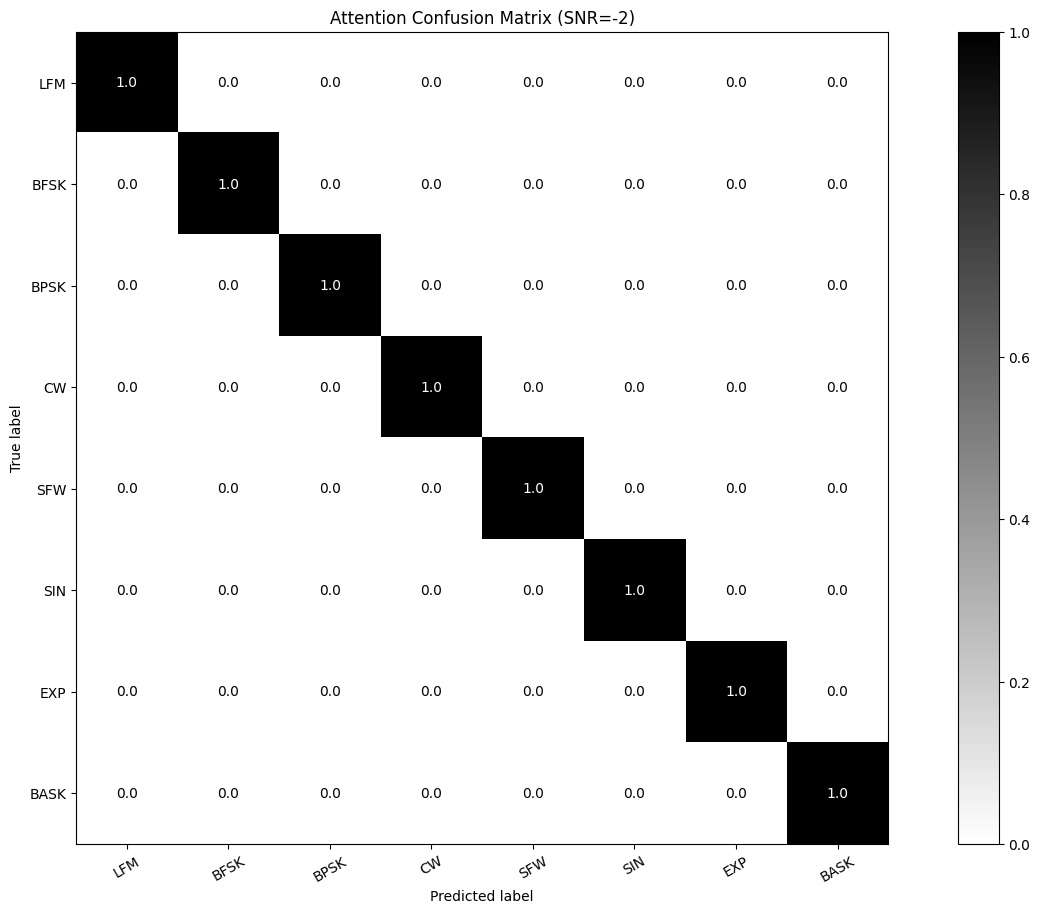

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

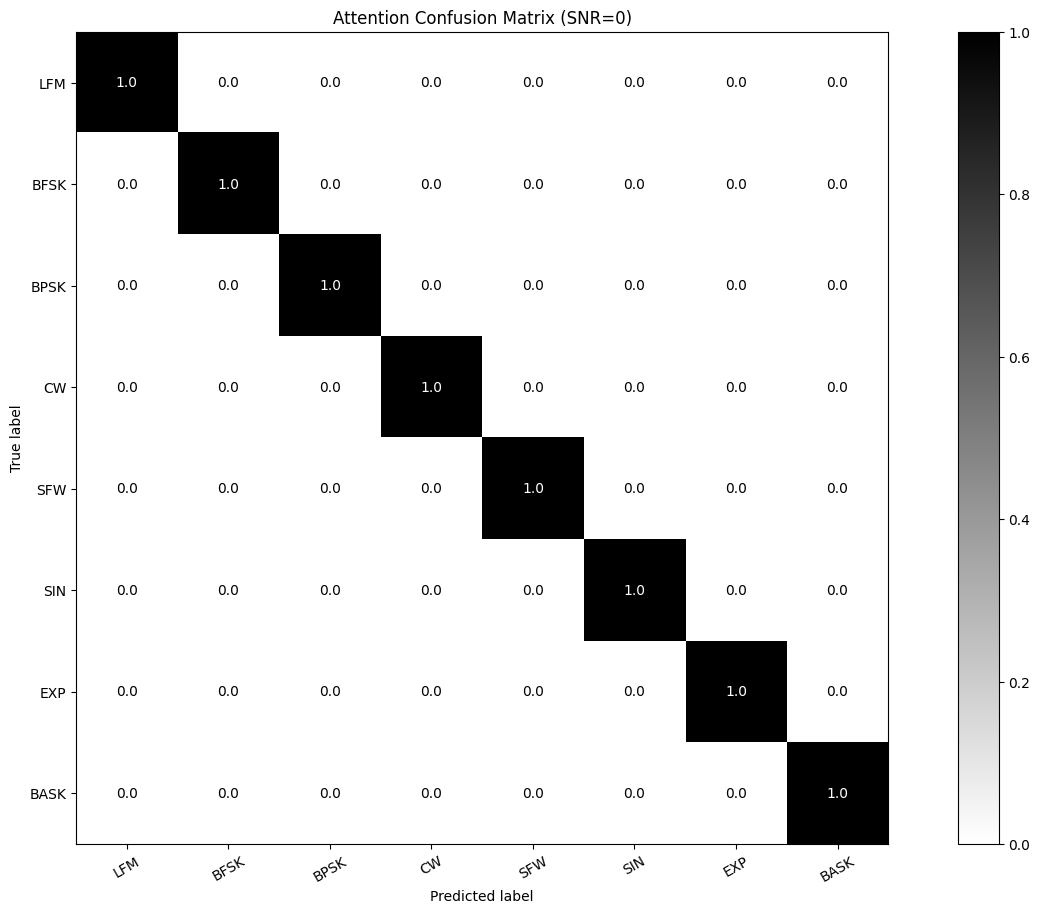

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

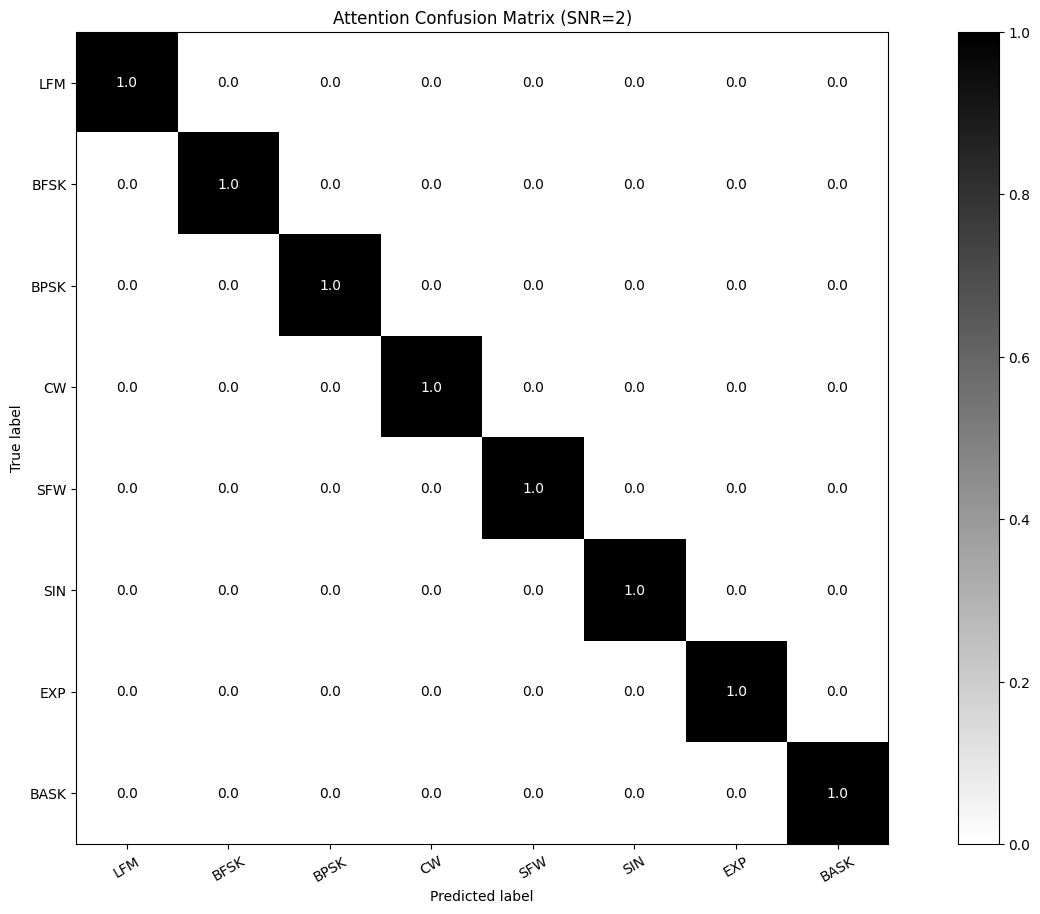

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

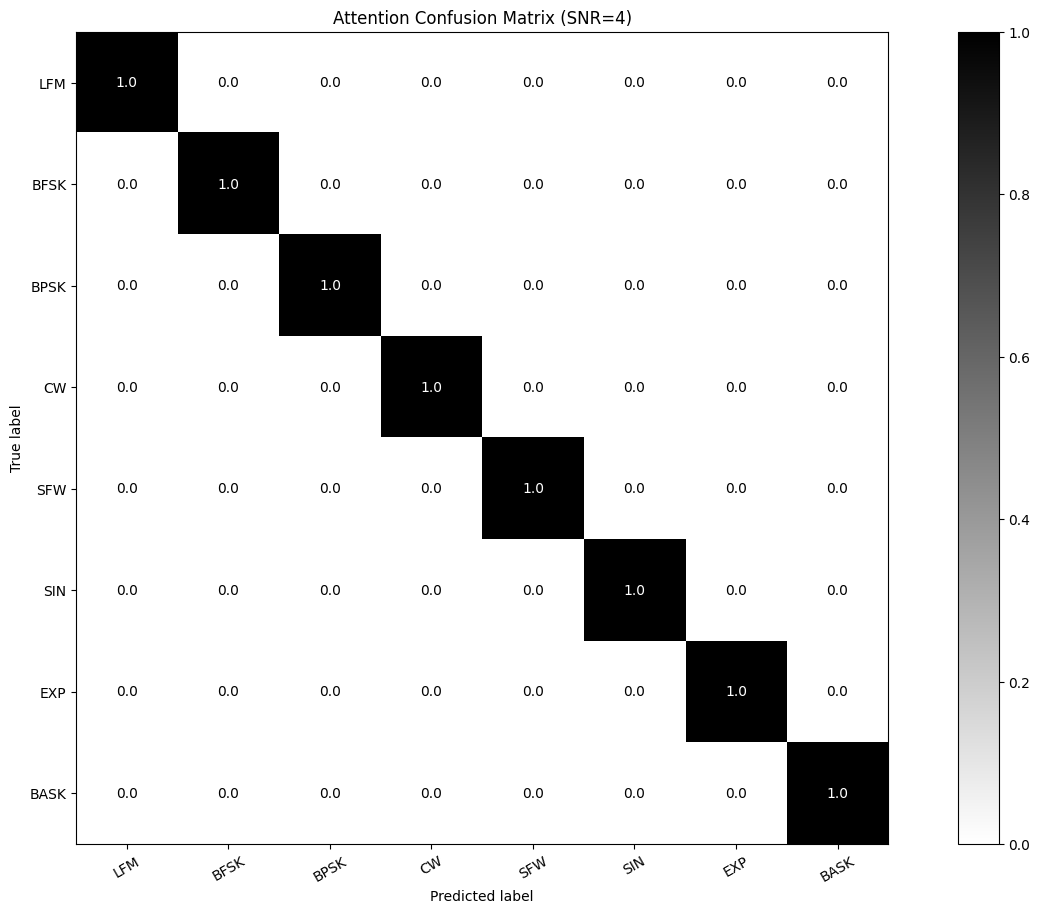

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

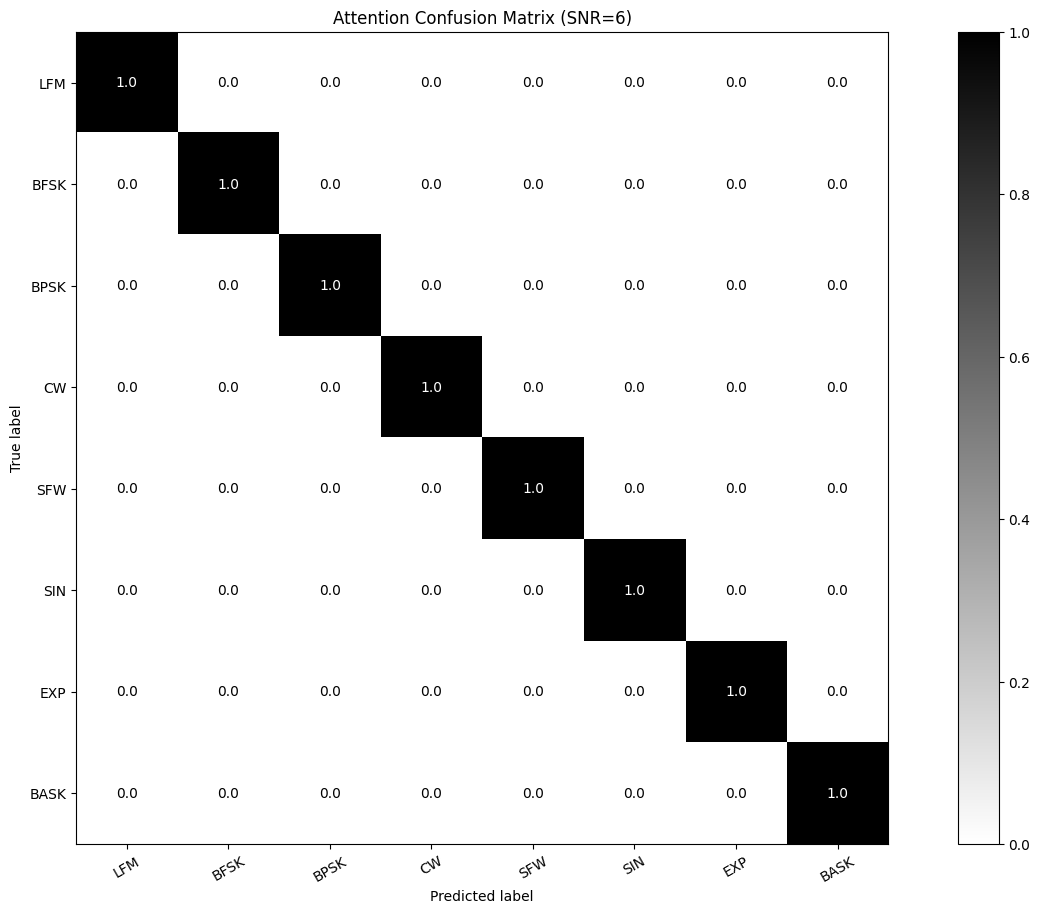

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

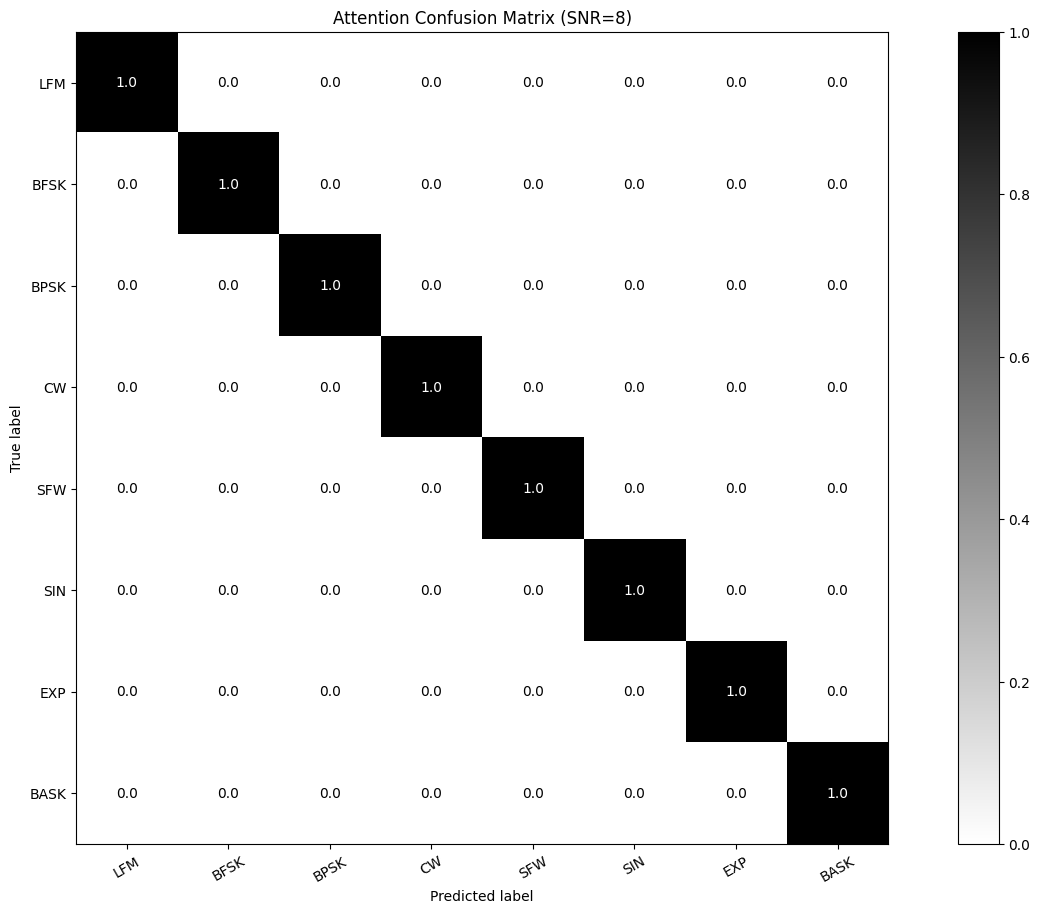

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

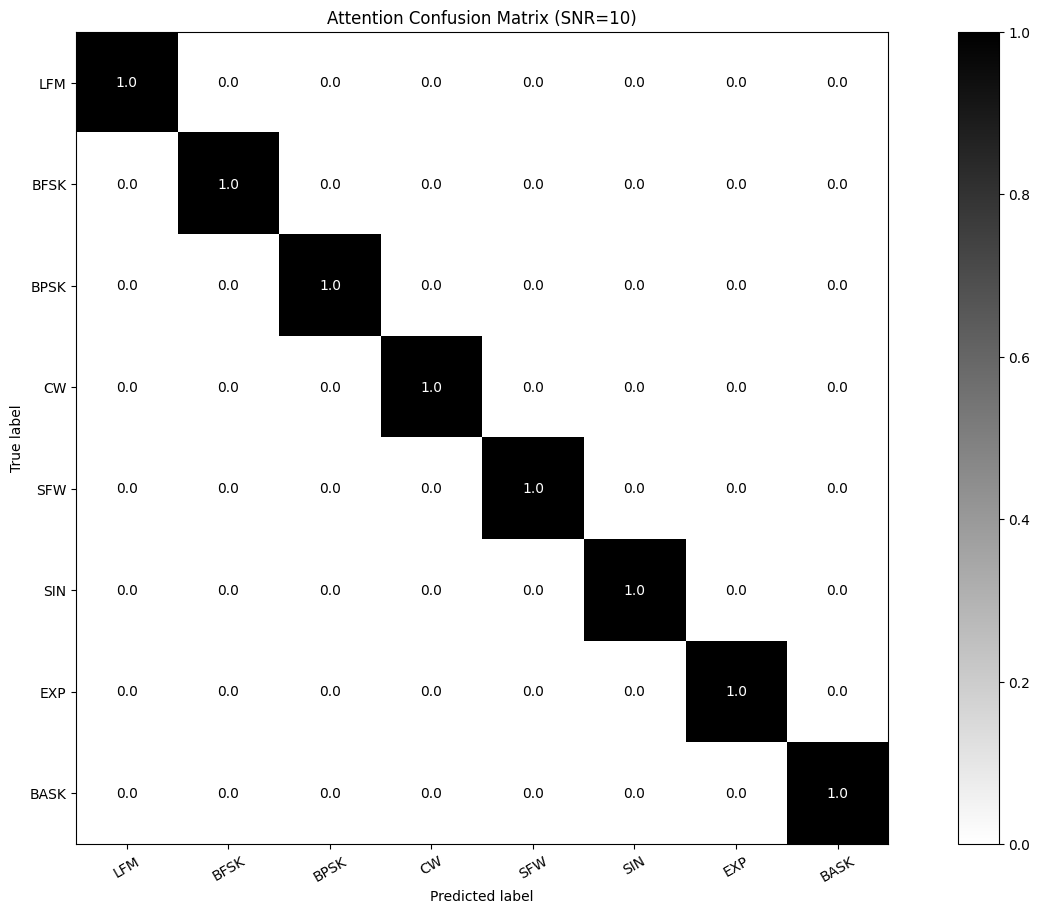

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

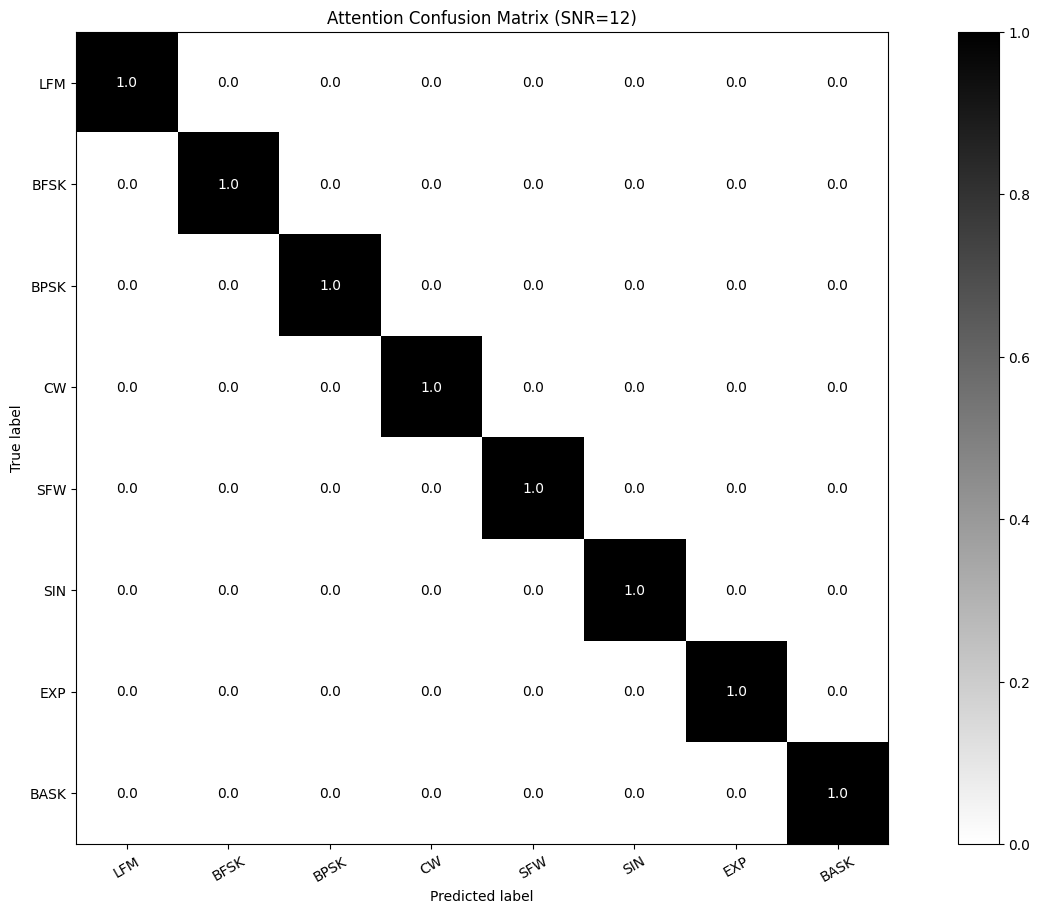

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

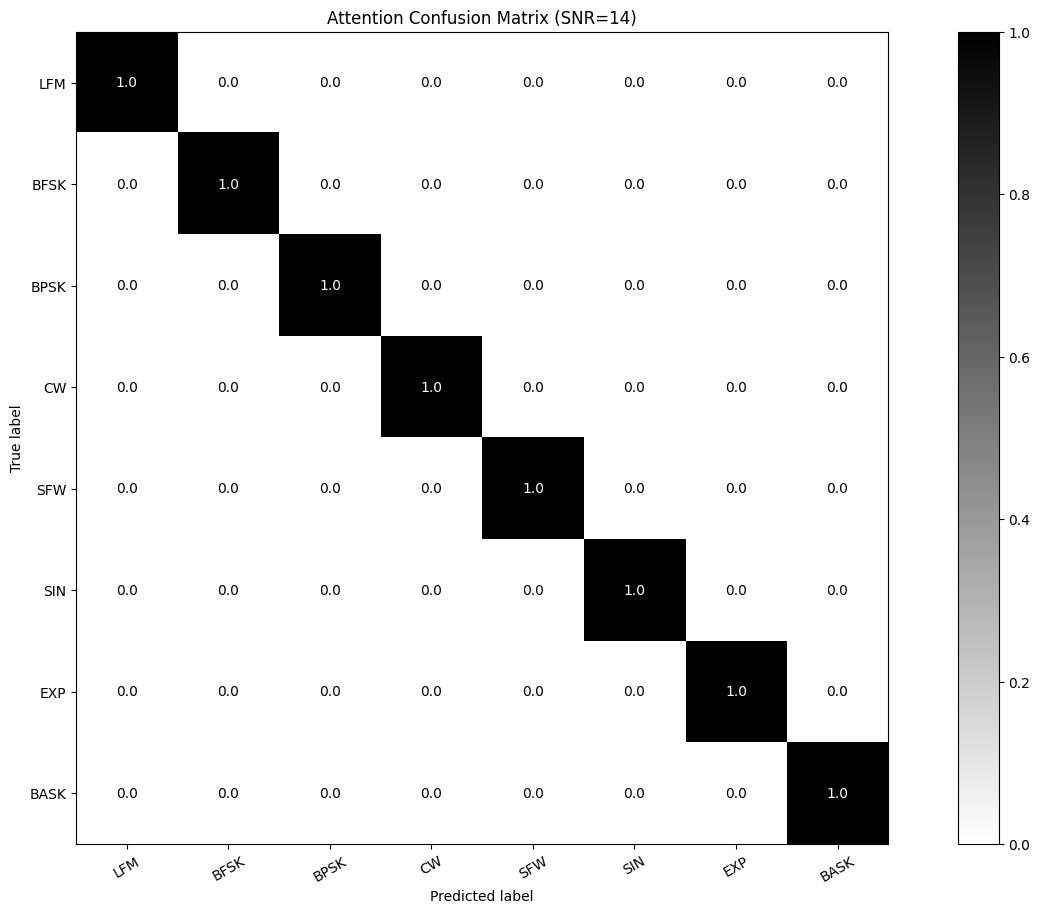

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

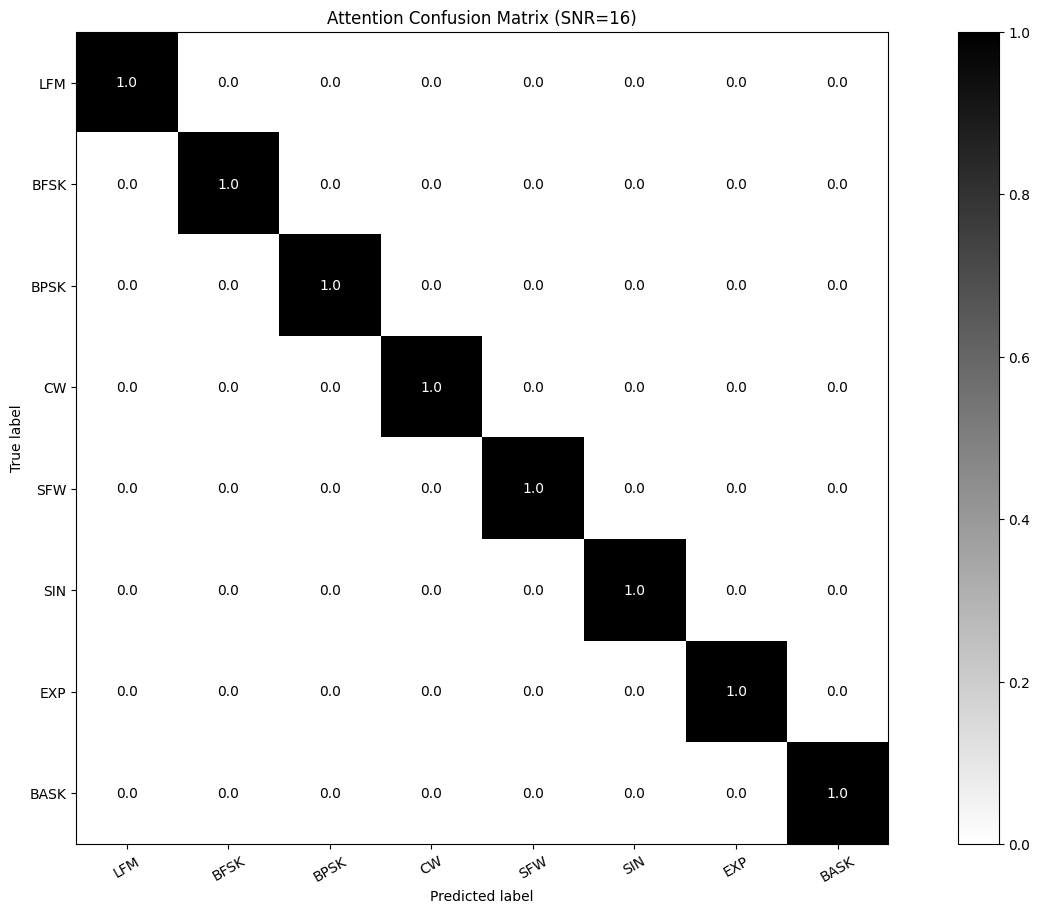

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

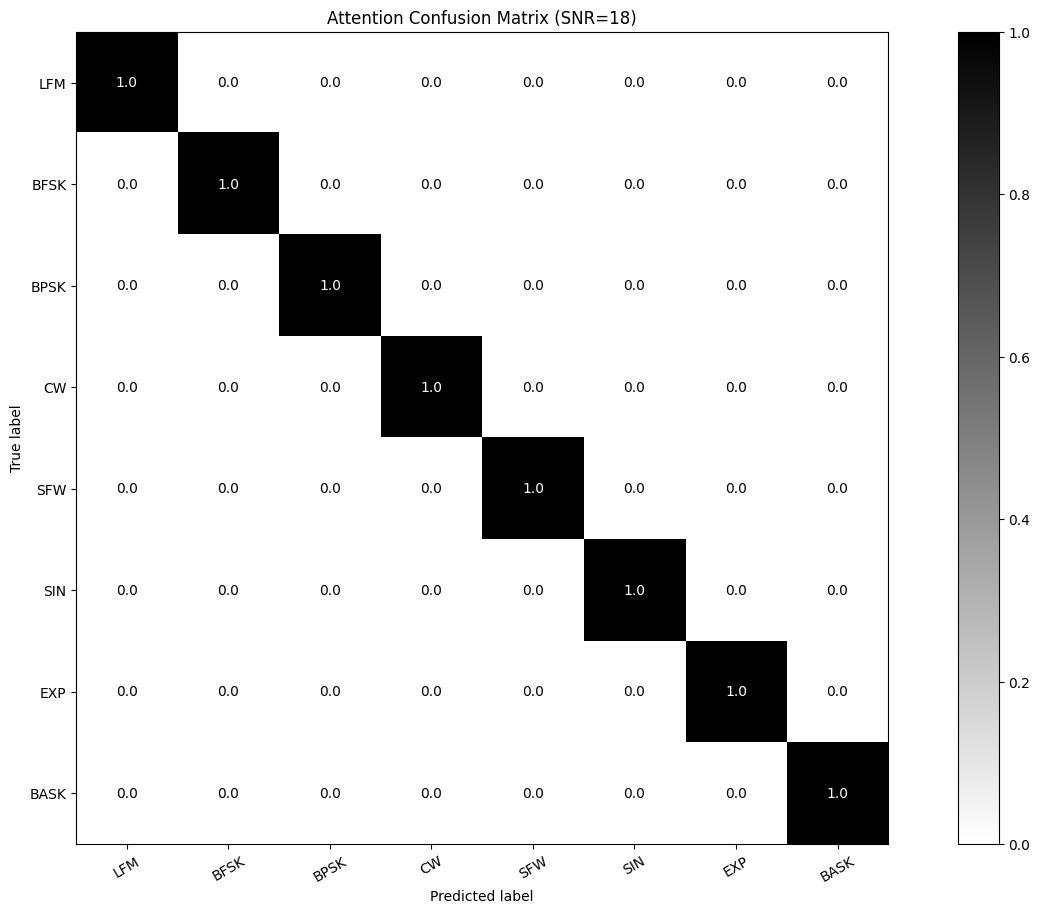

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1112.48 with 0 Axes>

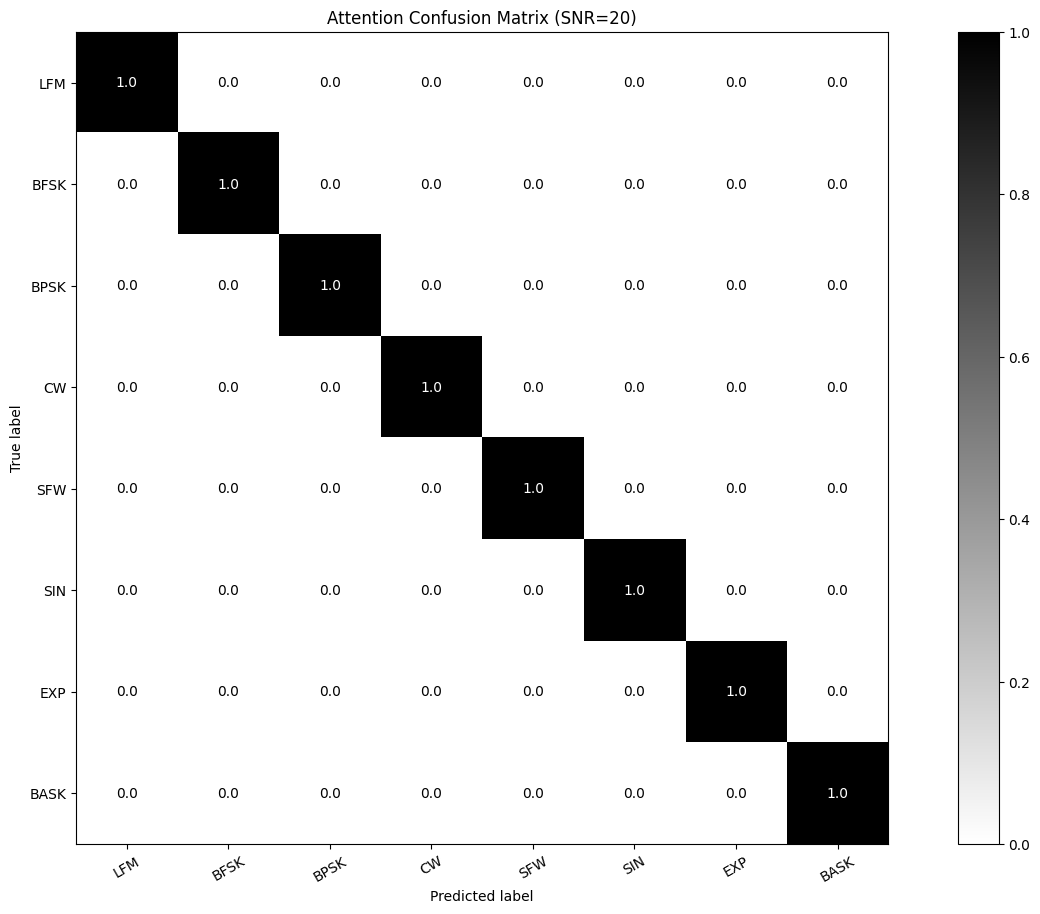

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
signal_class = {classes[0]: np.zeros(17), classes[1]: np.zeros(17),classes[2]:np.zeros(17), classes[3] : np.zeros(17), classes[4]: np.zeros(17), classes[5]:np.zeros(17), classes[6]:np.zeros(17), classes[7]:np.zeros(17)}
acc={}
snrs = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]

for j,snr in enumerate(snrs):
    test_SNRs = list(map(lambda x: lbl_test[x][1], range(0,X_test.shape[0])))
    test_X_i = X_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i = Y_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    # estimate classes
    test_Y_i_hat = np.array(model.predict(test_X_i))
    cm = confusion_matrix(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    for i in range(len(classes)):
        signal_class[classes[i]][j]= cm[i][i] 
    width = 18
    height = width / 1.618
    plt.figure(figsize=(width, height))
    plt = getConfusionMatrixPlot(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,
        1),title="Attention Confusion Matrix (SNR=%d)"%(snr))
    plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig(output_path + '/graphs/confmat_'+str(snr)+'.pdf')
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    cor = np.sum(np.diag(conf))
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
   # with open(output_path + '/acc.json', 'w') as f:
   #     json.dump(acc, f)
        

In [12]:
for k,val in signal_class.items():
    signal_class[k] = list([v*100for v in val])

In [29]:
y_true = [2, 0, 2, 2, 0, 3, 3]
y_pred = [0, 0, 2, 2, 0, 2, 3]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [1, 2, 0],
       [0, 1, 1]])

In [10]:
type(signal_class)

dict

In [13]:
with open(output_path + '/signal_acc.json', "w") as f:
    json.dump(signal_class, f)

In [25]:
import numpy

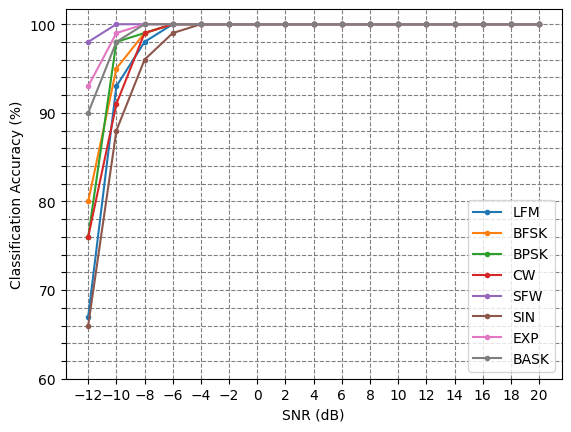

In [36]:
plt.figure()
ticks = []
a = numpy.arange(60, 102, 2)
for i in a:
    if i % 5 == 0:
        ticks.append(str(i))
    else:
        ticks.append("")
for i in range(len(classes)):
    plt.plot(snrs, signal_class[classes[i]], marker='.')
plt.legend(classes)
plt.yticks(a,ticks)
plt.xticks(snrs)
plt.grid(color = "grey", linewidth = "0.8", linestyle = "--")
plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy (%)")
plt.savefig(output_path+ '/graphs/signal_accuracy.pdf')
